# Septin Analysis: comparing the mean shape of each group

$\textbf{Lead Author:}$ Adele Myers

# 1. Overview of analysis

We calculate the mean shape of 1) Control Cells 2) Septin Overexpression Cells 3) Septin Knockdown Cells. Then we show how far each point lies from the mean shape

# 2. Imports

## 2.1 Notebook setup

In [307]:
import os
import subprocess
os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(geomstats_gitroot_path[:-1])
print("Working directory: ", os.getcwd())

import warnings
warnings.filterwarnings("ignore")

Working directory:  /Users/adelemyers/code/dyn


## 2.2 Standard Imports

In [308]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [309]:
from geomstats.learning.pca import TangentPCA

from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

## 2.3 Project-specific imports

In [310]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, ClosedDiscreteCurves

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.learning.mdm import RiemannianMinimumDistanceToMeanClassifier
from geomstats.learning.pca import TangentPCA

import dyn.dyn.datasets.experimental as experimental
import dyn.dyn.features.basic as basic
import dyn.viz as viz

viz.init_matplotlib()
%config InlineBackend.figure_formats = ['svg']

# 3. Setup

## 3.1 Load the datasets of interest

In [311]:
import dyn.dyn.datasets.experimental as experimental

#this forces the notebook to re-load
import importlib
importlib.reload(experimental)

control_centers, control_shapes, control_imgs, control_label = experimental.load_septin_cells( 'control',
    n_sampling_points=300)

knockdown_centers, knockdown_shapes, knockdown_imgs, knockdown_label = experimental.load_septin_cells( 'septin_knockdown',
    n_sampling_points=300)

overexp_centers, overexp_shapes, overexp_imgs, overexp_label = experimental.load_septin_cells( 'septin_overexpression',
    n_sampling_points=300)

Loading control data
n_sampling_points= 300
- Cell shapes: quotienting scaling (length).
- Cell shapes: quotienting rotation.
Loading septin_knockdown data
n_sampling_points= 300
- Cell shapes: quotienting scaling (length).
- Cell shapes: quotienting rotation.
Loading septin_overexpression data
n_sampling_points= 300
- Cell shapes: quotienting scaling (length).
- Cell shapes: quotienting rotation.


## 3.2 Define Shape Spaces

In [423]:
R1 = Euclidean(dim=1)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric
L2_METRIC = CURVES_SPACE.l2_curves_metric

ELASTIC_METRIC = {}
AS = [0.75, 0.5, 0.25, 0.01]
BS = [0.5, 0.5, 0.5, 0.5]
for a, b in zip(AS, BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric
    
    
METRICS = {}
METRICS["Linear"] = L2_METRIC
METRICS["SRV"] = SRV_METRIC

# 4. Sample Means

## 4.1 Control Means

We compare results when computing the mean cell versus the mean cell shapes with different elastic metrics.

In [424]:
control_means = {}

control_means["Linear"] = gs.mean(control_shapes, axis=0)
control_means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        point_type="matrix", 
        method="default").fit(control_shapes).estimate_
for a, b in zip(AS, BS):
    control_means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            point_type="matrix", 
            method="default").fit(control_shapes).estimate_

Now, we plot the cell shapes corresponding to the means with different metrics.

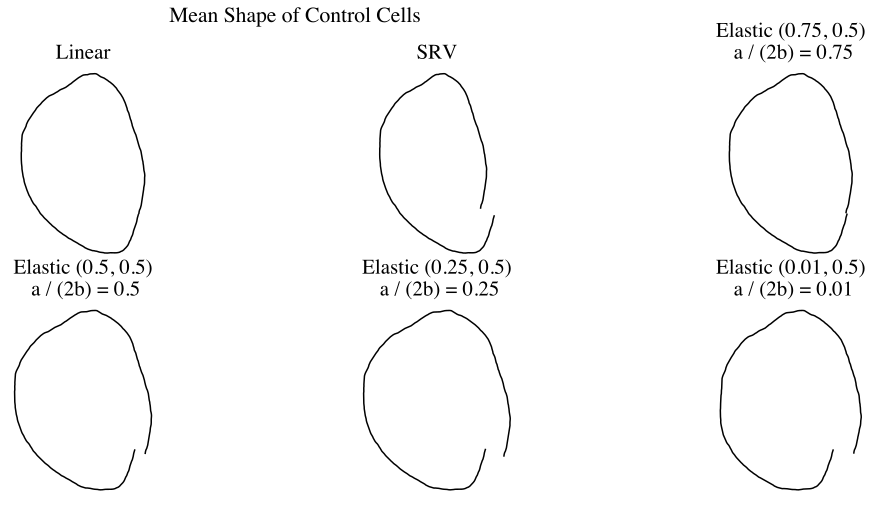

In [425]:
fig = plt.figure(figsize=(18, 8))

#plt.figtext(0.5, 1, 'Effect of bias addition', ha='right')

fig. suptitle("Mean Shape of Control Cells", ha='right')

ncols = len(control_means) // 2

for i, (mean_name, mean) in enumerate(control_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)

### IMPORTANT: 
now, we project these "open curve" shape onto the shape space manifold of closed curves. This does not change the mean shape information at all. Its only purpose is to give us the "closed curve" version of our previous results. We wish to do this because cells contours are closed curves, and thus it would be better for our results to also be closed curves. 

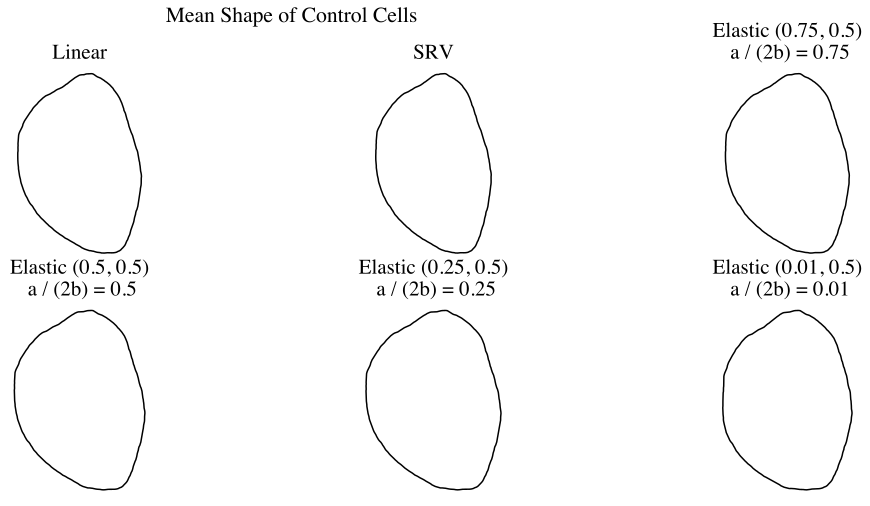

In [426]:
fig = plt.figure(figsize=(18, 8))

fig. suptitle("Mean Shape of Control Cells", ha='right')

ncols = len(control_means) // 2

for i, (mean_name, mean) in enumerate(control_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    mean = CLOSED_CURVES_SPACE.projection(mean)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
plt.savefig("dyn/saved_figs/Control_Means.png")

## 4.2 Septin Knockdown Means

In [427]:
knockdown_means = {}

knockdown_means["Linear"] = gs.mean(knockdown_shapes, axis=0)
knockdown_means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        point_type="matrix", 
        method="default").fit(knockdown_shapes).estimate_
for a, b in zip(AS, BS):
    knockdown_means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            point_type="matrix", 
            method="default").fit(knockdown_shapes).estimate_

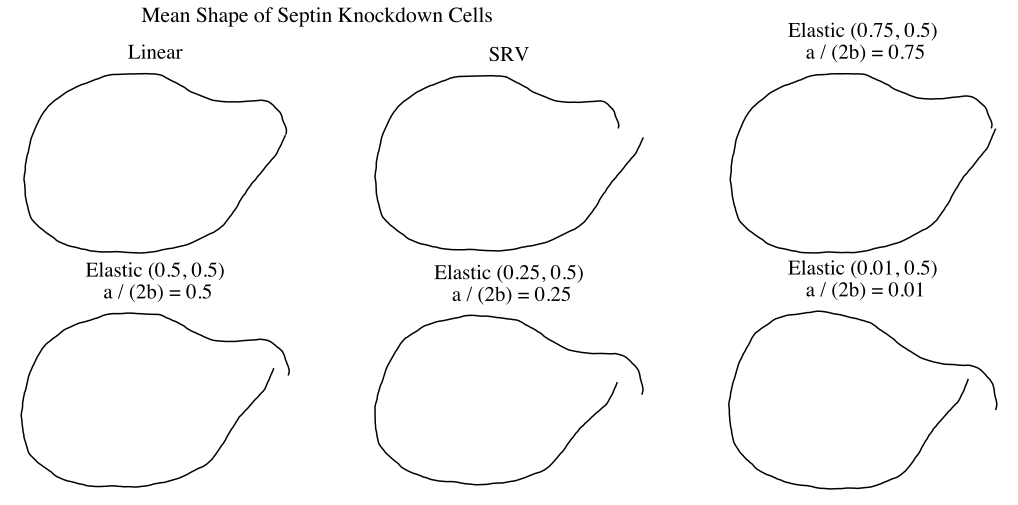

In [428]:
fig = plt.figure(figsize=(18, 8))

fig. suptitle("Mean Shape of Septin Knockdown Cells", ha='right')

ncols = len(knockdown_means) // 2

for i, (mean_name, mean) in enumerate(knockdown_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)

Again, we project the "open curve" results to the space of "closed curves" to get our final result:

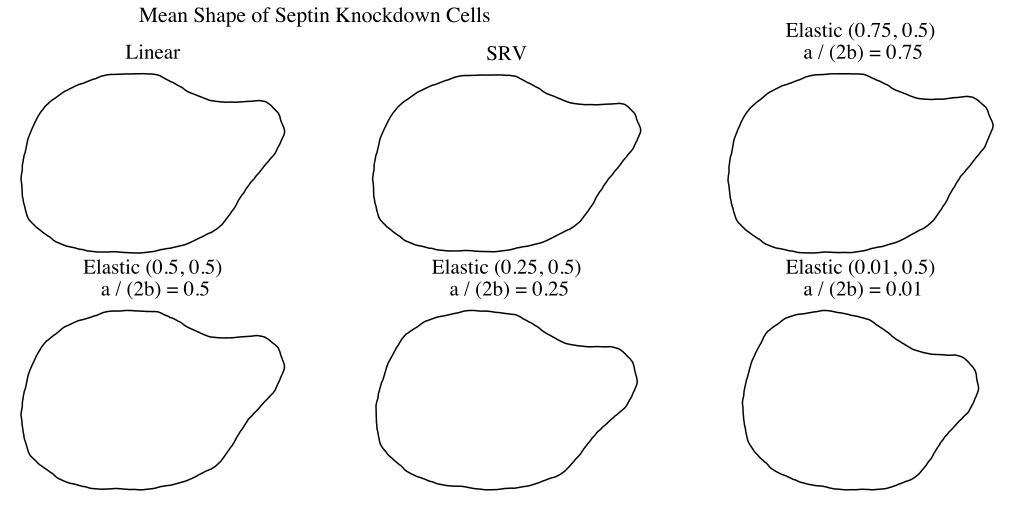

In [429]:
fig = plt.figure(figsize=(18, 8))

fig. suptitle("Mean Shape of Septin Knockdown Cells", ha='right')

ncols = len(knockdown_means) // 2

for i, (mean_name, mean) in enumerate(knockdown_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    mean = CLOSED_CURVES_SPACE.projection(mean)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
plt.savefig("dyn/saved_figs/Knockdown_Means.png")

## 4.2 Septin Overexpression Means

In [430]:
overexp_means = {}

overexp_means["Linear"] = gs.mean(overexp_shapes, axis=0)
overexp_means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        point_type="matrix", 
        method="default").fit(overexp_shapes).estimate_
for a, b in zip(AS, BS):
    overexp_means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            point_type="matrix", 
            method="default").fit(overexp_shapes).estimate_

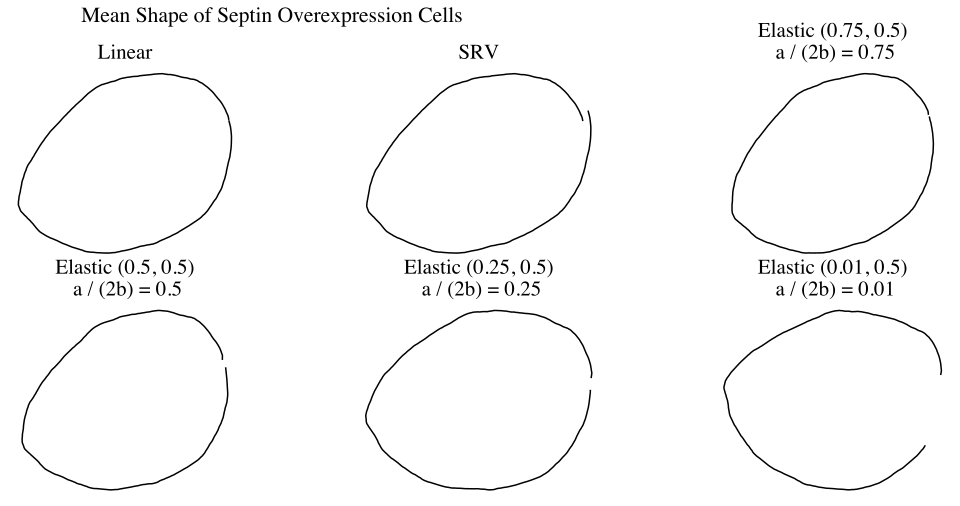

In [431]:
fig = plt.figure(figsize=(18, 8))

fig. suptitle("Mean Shape of Septin Overexpression Cells", ha='right')

ncols = len(overexp_means) // 2

for i, (mean_name, mean) in enumerate(overexp_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)

Once again, we project our "open space" curves to the space of "closed curves" to get our final result:

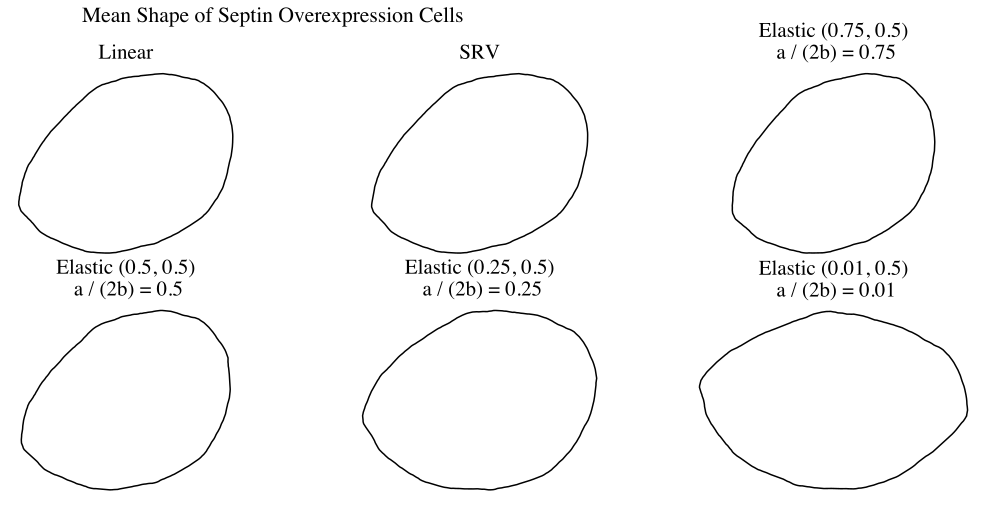

In [432]:
fig = plt.figure(figsize=(18, 8))

fig. suptitle("Mean Shape of Septin Overexpression Cells", ha='right')

ncols = len(overexp_means) // 2

for i, (mean_name, mean) in enumerate(overexp_means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    mean = CLOSED_CURVES_SPACE.projection(mean)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
plt.savefig("dyn/saved_figs/Overexpression_Means.png")

# 5. Analysis

- We see that the Control means are narrower ellipses with a small protrusion. 
- We see that the Septin Knockdown means shows a large protrusion. This reflects that on average, the septin knockdown cells have very large protrusions (potentially because septins are required for detachment, and the protrusions in this dataset are not detatching).
- We see that the Septin Overexpression means are wider ellipses with no obvious protrusion (potentially because septins are doing a VERY good job of detatching the protrusions so that there are not as many large protrusions in the dataset?).

-----
# Misc. Analyses:
-----

# 6. How far is each data point from the mean shape?

In this section, we compute how far each shape is from the mean (the distance between each shape and the mean). Then, we summarize this information in a histogram. these histograms show the distribution of datapoints' distances from the 'Linear' mean and the 'SRV metric' mean. 

In [433]:
n_sampling_points=300
label_name = 'treatment'

## 5.1 Distances to control mean

In [434]:
control_dists = {}

control_dists["Linear"] = [gs.linalg.norm(control_means["Linear"] - shape).numpy() / n_sampling_points for shape in control_shapes]

control_dists["SRV"] = [
    SRV_METRIC.dist(control_means["SRV"], shape).numpy() / n_sampling_points for shape in control_shapes
]

for a, b in zip(AS, BS):
    control_dists[a, b] =  [
    ELASTIC_METRIC[a, b].dist(control_means[a, b], shape).numpy() / n_sampling_points for shape in control_shapes
]

In [435]:
control_dists_summary = pd.DataFrame(
    data={
        label_name: control_label,
        "Linear": control_dists["Linear"],
        "SRV": control_dists["SRV"],
    }
)

for a, b in zip(AS, BS):
    control_dists_summary[f"Elastic({a}, {b})"] = control_dists[a, b]
    
control_dists_summary.head()

,treatment,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,control,0.001718,0.002198,0.001807,0.001301,0.000710,0.000244
1,control,0.001898,0.001924,0.001547,0.001102,0.000615,0.000272
2,control,0.000965,0.001768,0.001415,0.001007,0.000570,0.000276
3,control,0.001752,0.001883,0.001506,0.001069,0.000604,0.000295
4,control,0.001194,0.002197,0.001768,0.001254,0.000688,0.000276


In [436]:
print(len(control_dists_summary))

36


Now, we generate histograms showing how far points in the dataset are from the mean (for the linear and SRV metrics)

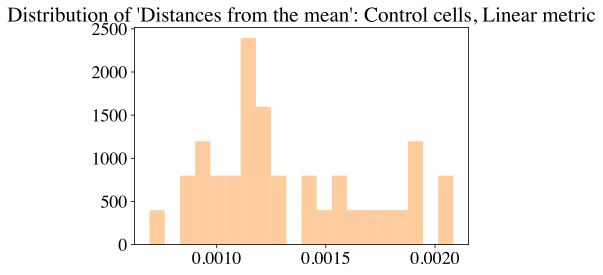

In [437]:
ds = control_dists_summary['Linear']
plt.hist(
            ds, bins=20, alpha=0.4, density=True, label='control', color=f"C{1}"
        )
plt.title("Distribution of 'Distances from the mean': Control cells, Linear metric")
plt.savefig("dyn/saved_figs/dist_control_linear.png")

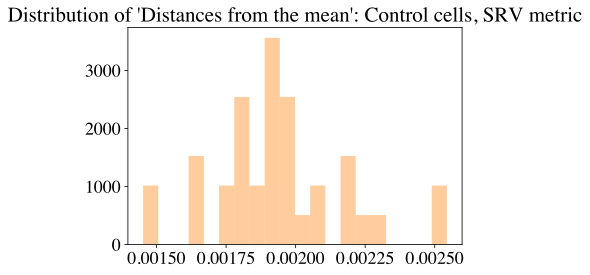

In [438]:
ds = control_dists_summary['SRV']
plt.hist(
            ds, bins=20, alpha=0.4, density=True, label='control', color=f"C{1}"
        )

plt.title("Distribution of 'Distances from the mean': Control cells, SRV metric")
plt.savefig("dyn/saved_figs/dist_control_SRV.png")

## 5.2 Distances from Septin Knockdown mean

In [439]:
knockdown_dists = {}

knockdown_dists["Linear"] = [gs.linalg.norm(knockdown_means["Linear"] - shape).numpy() / n_sampling_points for shape in knockdown_shapes]

knockdown_dists["SRV"] = [
    SRV_METRIC.dist(knockdown_means["SRV"], shape).numpy() / n_sampling_points for shape in knockdown_shapes
]

for a, b in zip(AS, BS):
    knockdown_dists[a, b] =  [
    ELASTIC_METRIC[a, b].dist(knockdown_means[a, b], shape).numpy() / n_sampling_points for shape in knockdown_shapes
]

In [440]:
knockdown_dists_summary = pd.DataFrame(
    data={
        label_name: knockdown_label,
        "Linear": knockdown_dists["Linear"],
        "SRV": knockdown_dists["SRV"],
    }
)

for a, b in zip(AS, BS):
    knockdown_dists_summary[f"Elastic({a}, {b})"] = knockdown_dists[a, b]
    
knockdown_dists_summary.head()

,treatment,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,septin_knockdown,0.001016,0.002008,0.001595,0.001127,0.000620,0.000266
1,septin_knockdown,0.002433,0.002025,0.001619,0.001165,0.000687,0.000387
2,septin_knockdown,0.001578,0.002327,0.001886,0.001349,0.000738,0.000259
3,septin_knockdown,0.002168,0.002686,0.002204,0.001582,0.000859,0.000235
4,septin_knockdown,0.001571,0.001974,0.001579,0.001122,0.000622,0.000273


Again, now we generate histograms that show the distribution of datapoints' distances from the Septin Knockdown mean

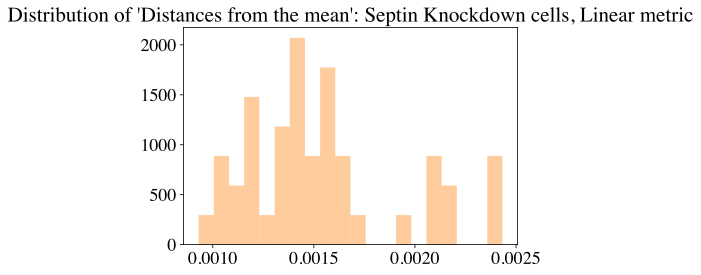

In [441]:
ds = knockdown_dists_summary['Linear']
plt.hist(
            ds, bins=20, alpha=0.4, density=True, label='control', color=f"C{1}"
        )
plt.title("Distribution of 'Distances from the mean': Septin Knockdown cells, Linear metric")
plt.savefig("dyn/saved_figs/dist_knockdown_linear.png")

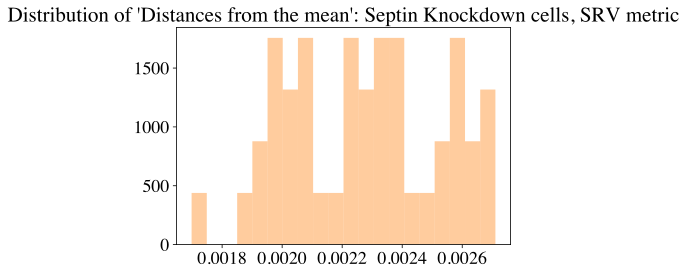

In [442]:
ds = knockdown_dists_summary['SRV']
plt.hist(
            ds, bins=20, alpha=0.4, density=True, label='control', color=f"C{1}"
        )
plt.title("Distribution of 'Distances from the mean': Septin Knockdown cells, SRV metric")
plt.savefig("dyn/saved_figs/dist_knockdown_SRV.png")

## 5.3 Distances for Septin Overexpression mean

In [443]:
overexp_dists = {}

overexp_dists["Linear"] = [gs.linalg.norm(overexp_means["Linear"] - shape).numpy() / n_sampling_points for shape in overexp_shapes]

overexp_dists["SRV"] = [
    SRV_METRIC.dist(overexp_means["SRV"], shape).numpy() / n_sampling_points for shape in overexp_shapes
]

for a, b in zip(AS, BS):
    overexp_dists[a, b] =  [
    ELASTIC_METRIC[a, b].dist(overexp_means[a, b], shape).numpy() / n_sampling_points for shape in overexp_shapes
]

In [444]:
overexp_dists_summary = pd.DataFrame(
    data={
        label_name: overexp_label,
        "Linear": overexp_dists["Linear"],
        "SRV": overexp_dists["SRV"],
    }
)

for a, b in zip(AS, BS):
    overexp_dists_summary[f"Elastic({a}, {b})"] = overexp_dists[a, b]
    
overexp_dists_summary.head()

,treatment,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,septin_overexpression,0.000857,0.001409,0.001135,0.000870,0.000526,0.000283
1,septin_overexpression,0.001712,0.001796,0.001467,0.001106,0.000644,0.000271
2,septin_overexpression,0.000908,0.001423,0.001136,0.000865,0.000514,0.000249
3,septin_overexpression,0.001035,0.001998,0.001591,0.001158,0.000671,0.000274
4,septin_overexpression,0.001302,0.001743,0.001409,0.001042,0.000596,0.000263


Again, now we generate histograms that show the distribution of datapoints' distances from the Septin Knockdown mean

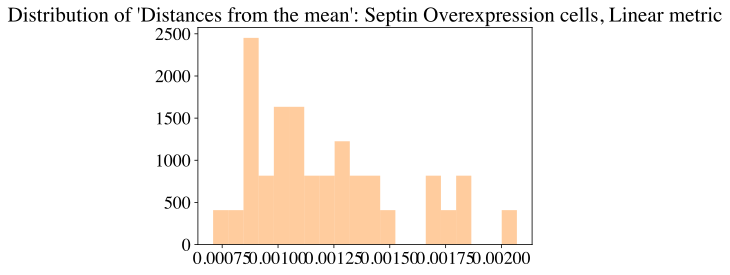

In [445]:
ds = overexp_dists_summary['Linear']
plt.hist(
            ds, bins=20, alpha=0.4, density=True, label='control', color=f"C{1}"
        )

plt.title("Distribution of 'Distances from the mean': Septin Overexpression cells, Linear metric")
plt.savefig("dyn/saved_figs/dist_overexp_linear.png")

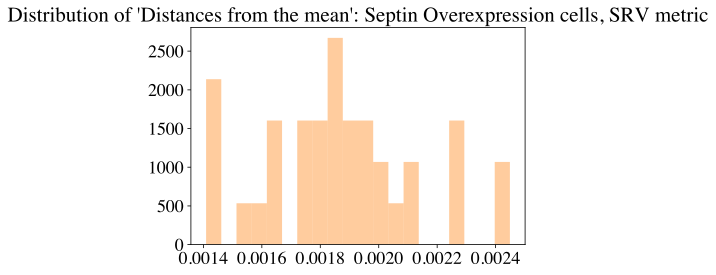

In [446]:
ds = overexp_dists_summary['SRV']
plt.hist(
            ds, bins=20, alpha=0.4, density=True, label='control', color=f"C{1}"
        )
plt.title("Distribution of 'Distances from the mean': Septin Overexpression cells, SRV metric")
plt.savefig("dyn/saved_figs/dist_overexp_SRV.png")

## 5.4 Graph with all three

In [447]:
total_dists_summary= [control_dists_summary,knockdown_dists_summary,overexp_dists_summary]

print(total_dists_summary[0].shape)
print(total_dists_summary[1].shape)
print(total_dists_summary[2])

(36, 7)
(45, 7)
                treatment    Linear       SRV  Elastic(0.75, 0.5)  \
0   septin_overexpression  0.000857  0.001409            0.001135   
1   septin_overexpression  0.001712  0.001796            0.001467   
2   septin_overexpression  0.000908  0.001423            0.001136   
3   septin_overexpression  0.001035  0.001998            0.001591   
4   septin_overexpression  0.001302  0.001743            0.001409   
5   septin_overexpression  0.000709  0.001789            0.001427   
6   septin_overexpression  0.001246  0.002010            0.001643   
7   septin_overexpression  0.001079  0.001627            0.001314   
8   septin_overexpression  0.000902  0.001906            0.001542   
9   septin_overexpression  0.001272  0.001631            0.001314   
10  septin_overexpression  0.001318  0.001971            0.001762   
11  septin_overexpression  0.001820  0.002281            0.001854   
12  septin_overexpression  0.001463  0.001830            0.001470   
13  septin_overexp

In [448]:
xx = {}

for metric_name in ["Linear", "SRV"]:
    min_dists = gs.array(min(dists_summary[metric_name]))
    max_dists = gs.array(max(dists_summary[metric_name]))
    xx[metric_name] = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), 100)

In [449]:
def hist_dists_to_means(total_dists_summary, label_color_incr):
    fig, axs = plt.subplots(1, 2, figsize=(18, 4))
    
    
    for i_metric, dist_name in enumerate(["Linear", "SRV"]):
        for i_group, group in enumerate(total_dists_summary):
            ds = total_dists_summary[i_group][dist_name]
            axs[i_metric].hist(
                ds, bins=20, alpha=0.4, density=True, label=total_dists_summary[i_group]['treatment'][0], 
                color=f"C{i_group+label_color_incr}"
                )
            kde = stats.gaussian_kde(ds)
            #axs[i].plot(xx[dist_name], kde(xx[dist_name]), color=f"C{i_lab+label_color_incr}")
        axs[i_metric].legend()
        axs[i_metric].set_title(f"Distances to\n {dist_name} mean\n colored by group\n ")
            
            
    fig, axs = plt.subplots(1, len(AS), figsize=(18, 2), #sharey=True
                           )
    
    for i_metric, (a, b) in enumerate(zip(AS, BS)):
        for i_group, group in enumerate(total_dists_summary):
            ds = total_dists_summary[i_group][f"Elastic({a}, {b})"]
            axs[i_metric].hist(
                ds, bins=20, alpha=0.4, density=True, label=total_dists_summary[i_group]['treatment'][0], 
                color=f"C{i_group+label_color_incr}"
                )
            kde = stats.gaussian_kde(ds)
            #axs[i].plot(xx[dist_name], kde(xx[dist_name]), color=f"C{i_lab+label_color_incr}")
        #axs[i_metric].legend()
        axs[i_metric].set_title(f"Distances to\n Elastic({a}, {b}) mean\n colored by group\n ")
    
    
            
        
        
    """
    for i, dist_name in enumerate(["Linear", "SRV"]):
        #for i_lab, label in enumerate(np.unique(labels)):
        ds = dists_summary[dist_name][dists_summary[labels_name] == label]
        axs[i].hist(
            ds, bins=20, alpha=0.4, density=True, label=label, color=f"C{i_lab+label_color_incr}"
        )
        kde = stats.gaussian_kde(ds)

        axs[i].plot(xx[dist_name], kde(xx[dist_name]), color=f"C{i_lab+label_color_incr}")
        axs[i].legend()
        axs[i].set_title(f"Distances to\n {dist_name} mean\n colored by {labels_name}\n ")


    fig, axs = plt.subplots(1, len(NEW_AS), figsize=(18, 2), sharey=True)

    for i, (a, b) in enumerate(zip(NEW_AS, NEW_BS)):
        for i_lab, label in enumerate(np.unique(labels)):
            ds = dists_summary[f"Elastic({a}, {b})"][dists_summary[labels_name] == label]
            axs[i].hist(
                ds, bins=20, alpha=0.4, density=True, label=label, color=f"C{i_lab+label_color_incr}"
            )
            kde = stats.gaussian_kde(ds)
            axs[i].plot(xx[metric_name], kde(xx[metric_name]), color=f"C{i_lab+label_color_incr}")
        axs[i].legend()
        axs[i].set_title(f"Distances to\n Elastic({a}, {b}) mean\n colored by {labels_name}\n")
    """

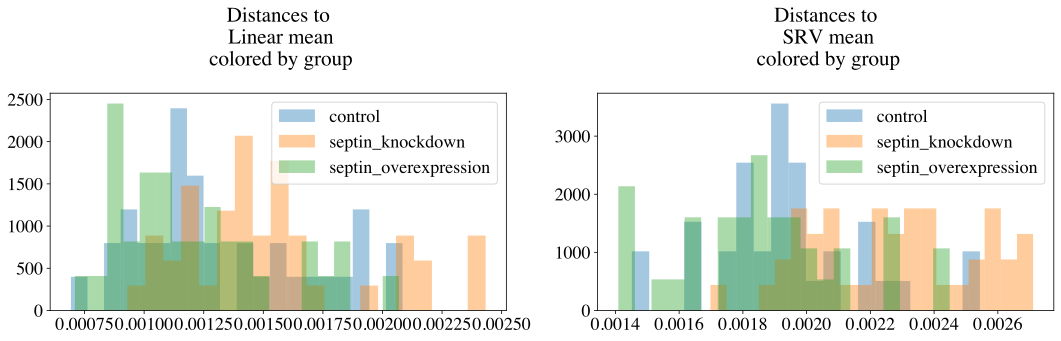

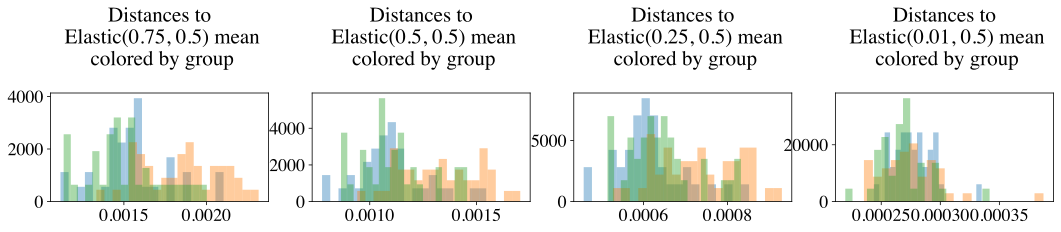

In [450]:
hist_dists_to_means(total_dists_summary, label_color_incr=0)

# 7. Clustering each set of data

Now, mostly for my own curiosity, i wanted to cluster the data.

## Description of k means algorithm

From [wikipedia](https://en.wikipedia.org/wiki/K-means_clustering): "that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster... k-means clustering minimizes within-cluster variances (squared Euclidean distances), but not regular Euclidean distances, which would be the more difficult Weber problem: the mean optimizes squared errors, whereas only the geometric median minimizes Euclidean distances. For instance, better Euclidean solutions can be found using k-medians and k-medoids." another useful [site](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1)

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

## clusters for control

In [262]:
# LINEAR
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)

#we are forced to use a 2D array (that is why we reshape)
control_dists_linear = np.array(control_dists["Linear"])
Kmean.fit(control_dists_linear.reshape(-1,1))

KMeans(n_clusters=3)

In [263]:
Kmean.cluster_centers_

array([[0.00123653],
       [0.0018122 ],
       [0.00092562]])

In [273]:
#Now, for SRV
Kmean = KMeans(n_clusters=3)

#we are forced to use a 2D array (that is why we reshape)
control_dists_linear = np.array(control_dists["SRV"])
Kmean.fit(control_dists_linear.reshape(-1,1))

KMeans(n_clusters=3)

In [274]:
Kmean.cluster_centers_

array([[0.00191797],
       [0.00231766],
       [0.00159146]])

## clusters for knockdown

In [267]:
# LINEAR
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)

#we are forced to use a 2D array (that is why we reshape)
knockdown_dists_linear = np.array(knockdown_dists["Linear"])
Kmean.fit(knockdown_dists_linear.reshape(-1,1))

KMeans(n_clusters=3)

In [268]:
Kmean.cluster_centers_

array([[0.00219774],
       [0.00113488],
       [0.00149454]])

In [275]:
#SRV
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)

#we are forced to use a 2D array (that is why we reshape)
knockdown_dists_linear = np.array(knockdown_dists["SRV"])
Kmean.fit(knockdown_dists_linear.reshape(-1,1))

KMeans(n_clusters=3)

In [276]:
Kmean.cluster_centers_

array([[0.00258507],
       [0.00197709],
       [0.0022887 ]])

## clusters for overexpression

In [271]:
# LINEAR
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)

#we are forced to use a 2D array (that is why we reshape)
overexp_dists_linear = np.array(overexp_dists["Linear"])
Kmean.fit(overexp_dists_linear.reshape(-1,1))

KMeans(n_clusters=3)

In [272]:
Kmean.cluster_centers_

array([[0.00181452],
       [0.00095379],
       [0.00130058]])

In [277]:
#SRV
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)

#we are forced to use a 2D array (that is why we reshape)
overexp_dists_linear = np.array(overexp_dists["SRV"])
Kmean.fit(overexp_dists_linear.reshape(-1,1))

KMeans(n_clusters=3)

In [278]:
Kmean.cluster_centers_

array([[0.00186132],
       [0.00225067],
       [0.00152626]])

Conclusions of misc. analyses: it does not seem like there are obvious "groups" within each dataset.